In [155]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import shap
from sklearn.inspection import permutation_importance
import torch 
import torch.nn as nn
import torch.nn.functional as F
from threshold_layer import ThresholdLayer
from utils import *
from torchviz import make_dot
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

data = pd.read_csv('monodata/mammographic.csv', header=None)

In [156]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## XGBoost

In [157]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}

xg_boost = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

grid_search = GridSearchCV(estimator=xg_boost, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Parameters:", best_params)
# print("Best Score:", best_score)

xg_boost = grid_search.best_estimator_

In [158]:
y_pred = xg_boost.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

y_pred_proba = xg_boost.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC: {roc_auc:.4f}')

Accuracy: 0.8133
F1 Score: 0.7862
ROC AUC: 0.8627


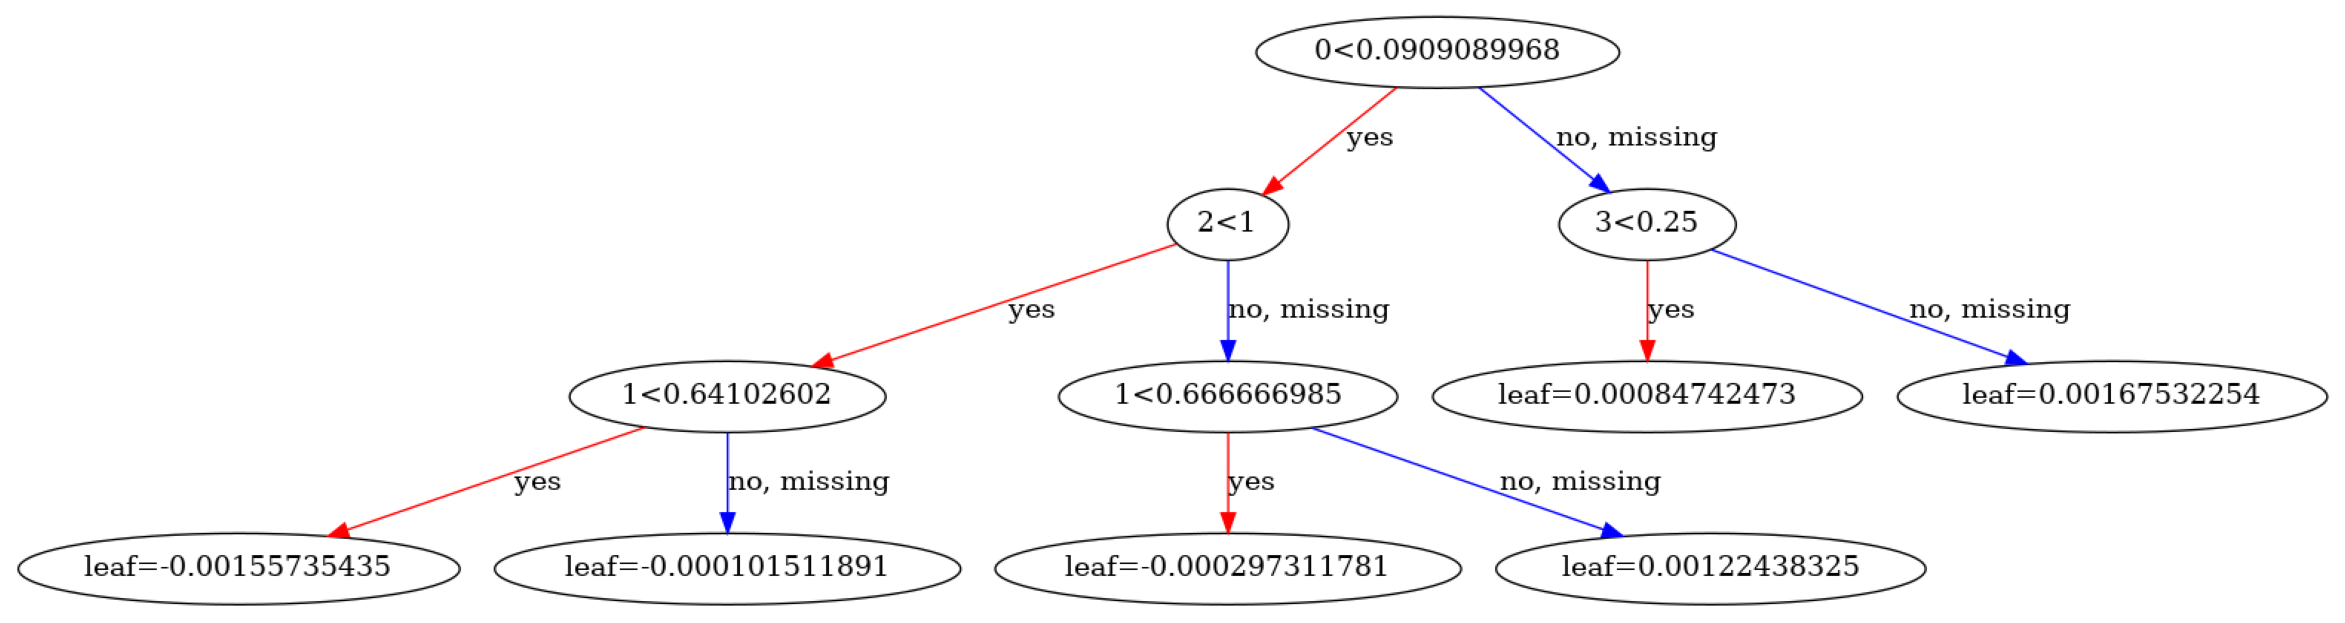

In [159]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(xg_boost, num_trees=6, ax=ax)
plt.show()

In [160]:
variant1 = X.iloc[13, :].values
variant2 = X.iloc[21, :].values
variant3 = X.iloc[117, :].values

predict1 = xg_boost.predict([variant1])
predict2 = xg_boost.predict([variant2])
predict3 = xg_boost.predict([variant3])

print(variant1, predict1)
print(variant2, predict2)
print(variant3, predict3)

[0.090909 0.307692 1.       0.75     0.666667] [1]
[0.072727 0.269231 0.       0.       0.333333] [0]
[0.072727 0.217949 0.       0.       0.333333] [0]


In [161]:
def find_minimal_change(model, variant):
    original_prediction = model.predict([variant])[0]
    for feature_index in range(len(variant)):
        for delta in np.arange(0.0001, 1.0001, 0.0001):
            variant_copy = variant.copy()
            variant_copy[feature_index] += delta
            variant_copy[feature_index] = min(1, variant_copy[feature_index])
            new_prediction = model.predict([variant_copy])[0]
            if new_prediction != original_prediction:
                return (feature_index, delta)
            
            variant_copy[feature_index] = variant[feature_index] - delta
            variant_copy[feature_index] = max(0, variant_copy[feature_index])
            new_prediction = model.predict([variant_copy])[0]
            if new_prediction != original_prediction:
                return (feature_index, -delta)
                
    return None

change1 = find_minimal_change(xg_boost, variant1)
change2 = find_minimal_change(xg_boost, variant2)
change3 = find_minimal_change(xg_boost, variant3)

print(f"Minimalna zmiana dla variant1: Cecha {change1[0]}, Zmiana {change1[1]}")
print(f"Minimalna zmiana dla variant2: Cecha {change2[0]}, Zmiana {change2[1]}")
print(f"Minimalna zmiana dla variant3: Cecha {change3[0]}, Zmiana {change3[1]}")

Minimalna zmiana dla variant1: Cecha 0, Zmiana -0.0001
Minimalna zmiana dla variant2: Cecha 0, Zmiana 0.0182
Minimalna zmiana dla variant3: Cecha 0, Zmiana 0.0182


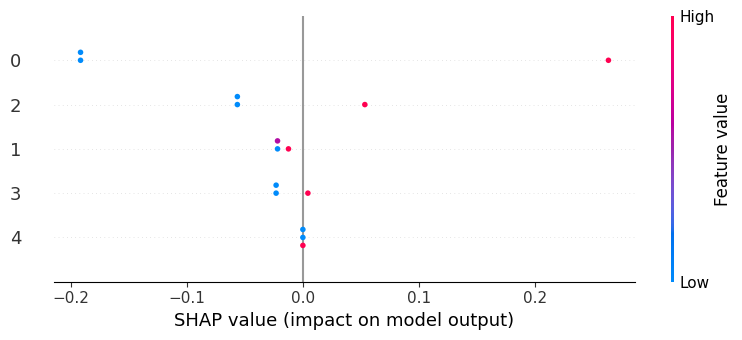

In [162]:
explainer = shap.TreeExplainer(xg_boost)

variants = np.array([variant1, variant2, variant3])

shap_values = explainer.shap_values(variants)

shap.summary_plot(shap_values, variants, feature_names=X.columns)

Feature: 0, Importance: 0.27349397590361446
Feature: 1, Importance: 0.031024096385542155
Feature: 2, Importance: 0.015963855421686723
Feature: 3, Importance: 0.0
Feature: 4, Importance: 0.0


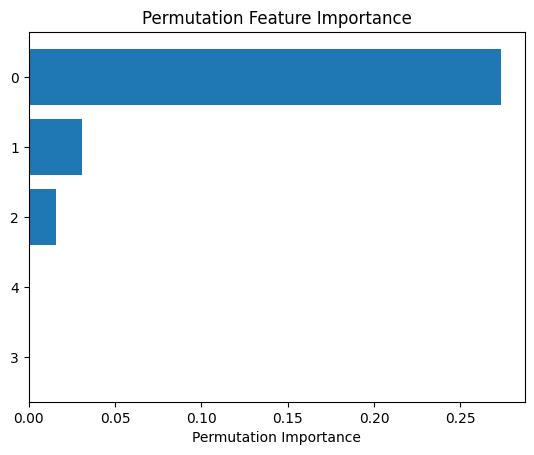

In [163]:
results = permutation_importance(xg_boost, X_train, y_train, scoring='accuracy')

for i in range(len(X_train.columns)):
    print(f"Feature: {X_train.columns[i]}, Importance: {results.importances_mean[i]}")

feature_names = X_train.columns
sorted_idx = np.argsort(results.importances_mean)
plt.barh(range(len(sorted_idx)), results.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Permutation Feature Importance")
plt.show()

## ANN-Ch-Constr

In [164]:
class LinearGreaterThanZero(nn.Linear):

    def __init__(self,in_features:int, bias:bool=False, min_w:float=0.0000001):
        super().__init__(in_features,1, bias)
        self.is_bias = bias
        self.min_w = min_w
        if bias:
            nn.init.uniform_(self.bias, self.min_w ,1.)
        else:
            self.bias = None

    def reset_parameters(self):
        nn.init.uniform_(self.weight, 0.1,1.)


    def w(self)->torch.Tensor:
        with torch.no_grad():
            self.weight.data[self.weight.data<0]=self.min_w
        return self.weight

    def forward(self, input:torch.Tensor)->torch.Tensor:
        return F.linear(input, self.w(), self.bias)


In [165]:
class LinearInteraction(nn.Linear):

    def __init__(self,in_features:int, criterion_layer:LinearGreaterThanZero):
        super().__init__(((in_features-1)*in_features)//2,1, False)
        self.in_features = in_features
        self.criterion_layer = criterion_layer
        
    def reset_parameters(self):
        nn.init.normal_(self.weight, 0.0,0.1)     
    
    def w(self)->torch.Tensor:
        with torch.no_grad():
            w_i=0
            w = self.criterion_layer.w()
            for i in range(self.in_features):
                for j in range(i+1,self.in_features):
                    self.weight.data[:,w_i] =  torch.max(self.weight.data[:,w_i], -w[:,i])
                    self.weight.data[:,w_i] =  torch.max(self.weight.data[:,w_i], -w[:,j])
                    w_i+=1
        return self.weight
        
    def forward(self, input:torch.Tensor)->torch.Tensor:
        return F.linear(input, self.w(), None)

In [166]:
class ChoquetIntegralConstrained(nn.Module):
    def __init__(self, num_criteria:int):
        super().__init__()
        self.num_criteria = num_criteria
        self.criteria_layer = LinearGreaterThanZero(num_criteria)
        self.interaction_layer = LinearInteraction(num_criteria,self.criteria_layer)
        self.threshold_layer = ThresholdLayer()
    
    def forward(self, input:torch.Tensor)->torch.Tensor:
        if len(input.shape)==3:
            input = input[:,0,:]
        
        x_wi = self.criteria_layer(input[:,:self.num_criteria])     
        x_wij = self.interaction_layer(input[:,self.num_criteria:])
        weight_sum = self.criteria_layer.w().sum()+self.interaction_layer.w().sum()
        score =  (x_wi+x_wij)/(weight_sum)
        return self.threshold_layer(score)

In [167]:
def mobious_transform(row:list|np.ndarray)->list:
    return  list(row) + [min(row[i],row[j]) for i in range(len(row)) for j in range(i+1,len(row))]

In [168]:
num_criteria = X.shape[1]

data_input = data.iloc[:,:num_criteria].apply(lambda x: mobious_transform(x),axis=1, result_type ='expand')
data_target = data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(data_input.values,
                                                    data_target.values,
                                                    test_size=0.2,
                                                    random_state=1234)

train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)

In [169]:
choq = ChoquetIntegralConstrained(num_criteria)
best_acc, best_auc,stats_train, stats_test = Train(choq, train_dataloader, test_dataloader, 'choquet.pt', lr=0.01, epoch_nr=50)

100%|██████████| 50/50 [00:01<00:00, 35.39it/s]


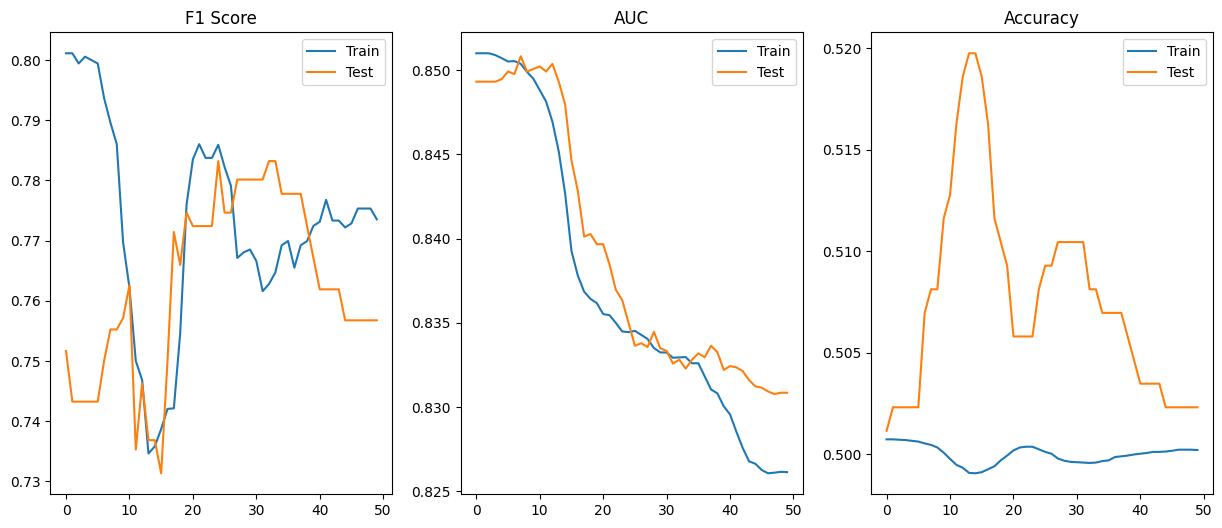

In [170]:
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(131)
ax.plot(stats_train.f1_scores,label='Train')
ax.plot(stats_test.f1_scores,label='Test')
ax.set_title('F1 Score')
ax.legend()

ax = fig.add_subplot(1,3,2)
ax.plot(stats_train.auc_scores,label='Train')
ax.plot(stats_test.auc_scores,label='Test')
ax.set_title('AUC')
ax.legend()

ax = fig.add_subplot(1,3,3)
ax.plot(stats_train.acc_scores,label='Train')
ax.plot(stats_test.acc_scores,label='Test')
ax.set_title('Accuracy')
ax.legend()

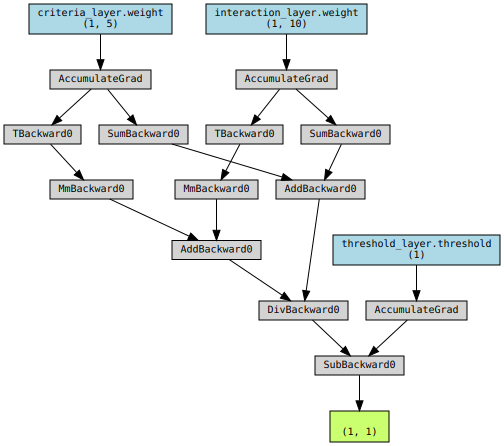

In [171]:
sample_input = torch.tensor(X_train[:1], dtype=torch.float32)
output = choq(sample_input)
dot = make_dot(output, params=dict(choq.named_parameters()))

dot

In [172]:
choq.eval()

variant1 = X.iloc[13, :].values
variant2 = X.iloc[21, :].values
variant3 = X.iloc[117, :].values

variant1_transformed = mobious_transform(variant1)
variant2_transformed = mobious_transform(variant2)
variant3_transformed = mobious_transform(variant3)

variants_transformed = np.stack([variant1_transformed, variant2_transformed, variant3_transformed])

variants_tensor = torch.tensor(variants_transformed, dtype=torch.float32)

with torch.no_grad():
    predictions = choq(variants_tensor)

predictions = predictions.numpy()

threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

print(variant1, binary_predictions[0])
print(variant2, binary_predictions[1])
print(variant3, binary_predictions[2])

[0.090909 0.307692 1.       0.75     0.666667] [0]
[0.072727 0.269231 0.       0.       0.333333] [0]
[0.072727 0.217949 0.       0.       0.333333] [0]


In [173]:
def predict_class(model, variant):
    transformed_variant = mobious_transform(variant)
    variant_tensor = torch.tensor([transformed_variant], dtype=torch.float32)
    with torch.no_grad():
        prediction = model(variant_tensor).item()
    return 1 if prediction > 0 else 0

def find_minimal_change(model, variant):
    original_class = predict_class(model, variant)
    
    for feature_index in range(len(variant)):
        for delta in np.arange(0.01, 1.01, 0.01):
            variant_copy = variant.copy()
            variant_copy[feature_index] += delta
            variant_copy[feature_index] = min(1, variant_copy[feature_index])
            new_class = predict_class(model, variant_copy)
            if new_class != original_class:
                return (feature_index, delta)
            
            variant_copy[feature_index] = variant[feature_index] - delta
            variant_copy[feature_index] = max(0, variant_copy[feature_index])
            new_class = predict_class(model, variant_copy)
            if new_class != original_class:
                return (feature_index, -delta)
                
    return None

min_change1 = find_minimal_change(choq, variant1)
min_change2 = find_minimal_change(choq, variant2)
min_change3 = find_minimal_change(choq, variant3)

print(f"Minimalna zmiana dla variant1: Cecha {min_change1[0]}, Zmiana {min_change1[1]}")
print(f"Minimalna zmiana dla variant2: Cecha {min_change2[0]}, Zmiana {min_change2[1]}")
print(f"Minimalna zmiana dla variant3: Cecha {min_change3[0]}, Zmiana {min_change3[1]}")

Minimalna zmiana dla variant1: Cecha 0, Zmiana -0.04
Minimalna zmiana dla variant2: Cecha 0, Zmiana 0.42000000000000004
Minimalna zmiana dla variant3: Cecha 0, Zmiana 0.44


ExactExplainer explainer: 4it [00:15, 15.29s/it]               


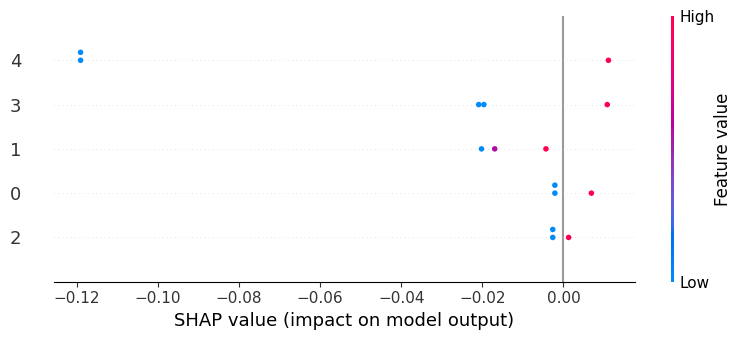

In [174]:
def predict_class(variants):
    predictions = []
    for variant in variants:
        transformed_variant = mobious_transform(variant)
        variant_tensor = torch.tensor([transformed_variant], dtype=torch.float32)
        with torch.no_grad():
            prediction = choq(variant_tensor).item()
        predictions.append(prediction)
    return predictions

explainer = shap.Explainer(predict_class, X.values)

variants = np.array([variant1, variant2, variant3])

shap_values = explainer(variants)

shap.summary_plot(shap_values, variants, feature_names=X.columns)